In [2]:
# %%
# %%
import os
import sys
import numpy as np
import torch
# from torch.utils.data import TensorDataset, DataLoader

# DL-Kit
sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/dl-kit') #TODO adjust path
sys.path.append('/projects/ecrpstats/dl-kit') #TODO adjust path
from dlkit.log.log_util import (logging_set_up, logging_get_logger)
# from dlkit.nets.mlp import MLPModel
from dlkit.opt.train import train_epochs
from dlkit.nets.conv2d import Conv2dUpscaleModelInterpolate

## Load model module
sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/paper_repo/auxilary_modules') #TODO adjust path
sys.path.append('/projects/ecrpstats/distributional_SRCNN/auxilary_modules')
import data_loading
import plotting

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd

train_or_load = 'train'
# %%
hr_data_size = 64
lr_data_size = 8

# %%
epochs = 500
batch_size = 32
##
region = 0
subregion = 'all'

# %%
## import data
xtrainHR, xtestHR, xtrainLR, xtestLR = data_loading.import_data(
    region,
    subregion,
    train_fraction=.7, 
    order='(time, subregion)'
    )

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
    )
print(f"Using device: {device}")

Using device: cpu


Define basis functions

In [4]:
N = 64
def compl_dft_basis(x, y, k_x, k_y):
    return np.exp(1j * 2*np.pi * (k_x*x + k_y*y)/N)

## Generate grid
x = np.arange(0, N)
xg = np.tile(x, N)           
yg = np.repeat(x, N, axis=0)
mat_xg = xg.reshape((64, 64))
mat_yg = yg.reshape((64, 64))

## Create basis functions to max period
# max_T = 20
# min_k = int(N/max_T)
min_k = 0
print(f"min k : {min_k}")
# max_k = (N)//2
max_k = (N)//2 + 1
print(f"max k : {max_k}")

basis_function_k_idx = []
basis_functions = []
for _kx in range(min_k, max_k):
    for _ky in range(min_k, max_k):
        basis_functions.append(
            compl_dft_basis(
                mat_xg, 
                mat_yg, 
                _kx, 
                _ky
                )
            )
        basis_function_k_idx.append((_kx, _ky))
        
basis_functions = np.asarray(basis_functions).reshape((-1, 64**2)).T
basis_functions.shape

min k : 0
max k : 33


(4096, 1089)

In [5]:
## Generate complex tensor
basis_functions_tensor = torch.tensor(basis_functions, dtype=torch.complex64).to(device)

# Load params

In [6]:
mse_g_params = np.load("../stage_2/anal_sln_global_params.npy")

In [7]:

## Invert covariance
mse_g_fit_cov = torch.real(
    torch.matmul(
        basis_functions_tensor/N, 
        torch.matmul(
            torch.diag_embed(torch.tensor(mse_g_params, dtype=torch.complex64)),
            torch.conj(basis_functions_tensor.T)/N
            )
        )
)

In [8]:
torch.matmul(
            torch.diag_embed(torch.tensor(mse_g_params, dtype=torch.complex64)),
            torch.conj(basis_functions_tensor.T)/N
            ).shape

torch.Size([1089, 4096])

Text(0.5, 1.0, 'fit covaraince')

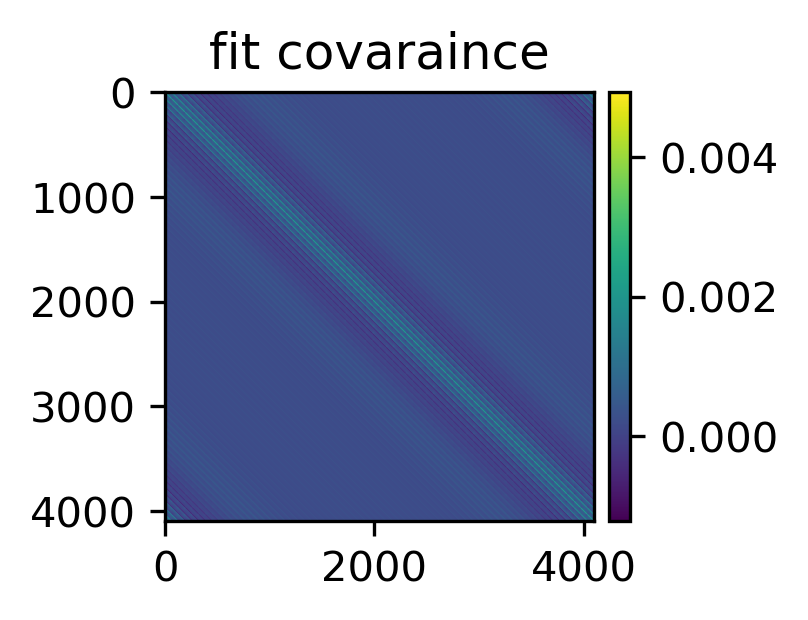

In [9]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(2, 2))

mse_g_fit_cov = mse_g_fit_cov.detach().numpy()

_plot = ax.imshow(mse_g_fit_cov)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # Size is width, pad is spacing
fig.colorbar(_plot, cax=cax)
ax.set_title('fit covaraince')



Text(0.5, 1.0, 'fit covaraince (first 4 blocks)')

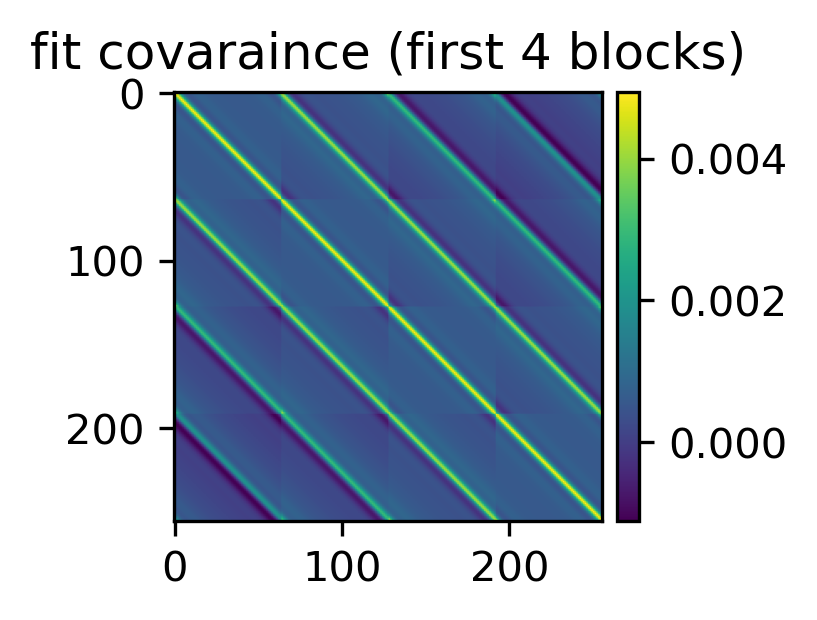

In [10]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(2, 2))

# mse_g_fit_cov = fit_cov.detach().numpy()

_plot = ax.imshow(mse_g_fit_cov[:64*4, :64*4])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # Size is width, pad is spacing
fig.colorbar(_plot, cax=cax)
ax.set_title('fit covaraince (first 4 blocks)')



/var/folders/k5/f6wjdcgd45n9wdxqb2g5v86m8nrvk5/T/ipykernel_24580/809768113.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  s_of_k[_kx, _ky] += this_s[_kx*33 + _ky]


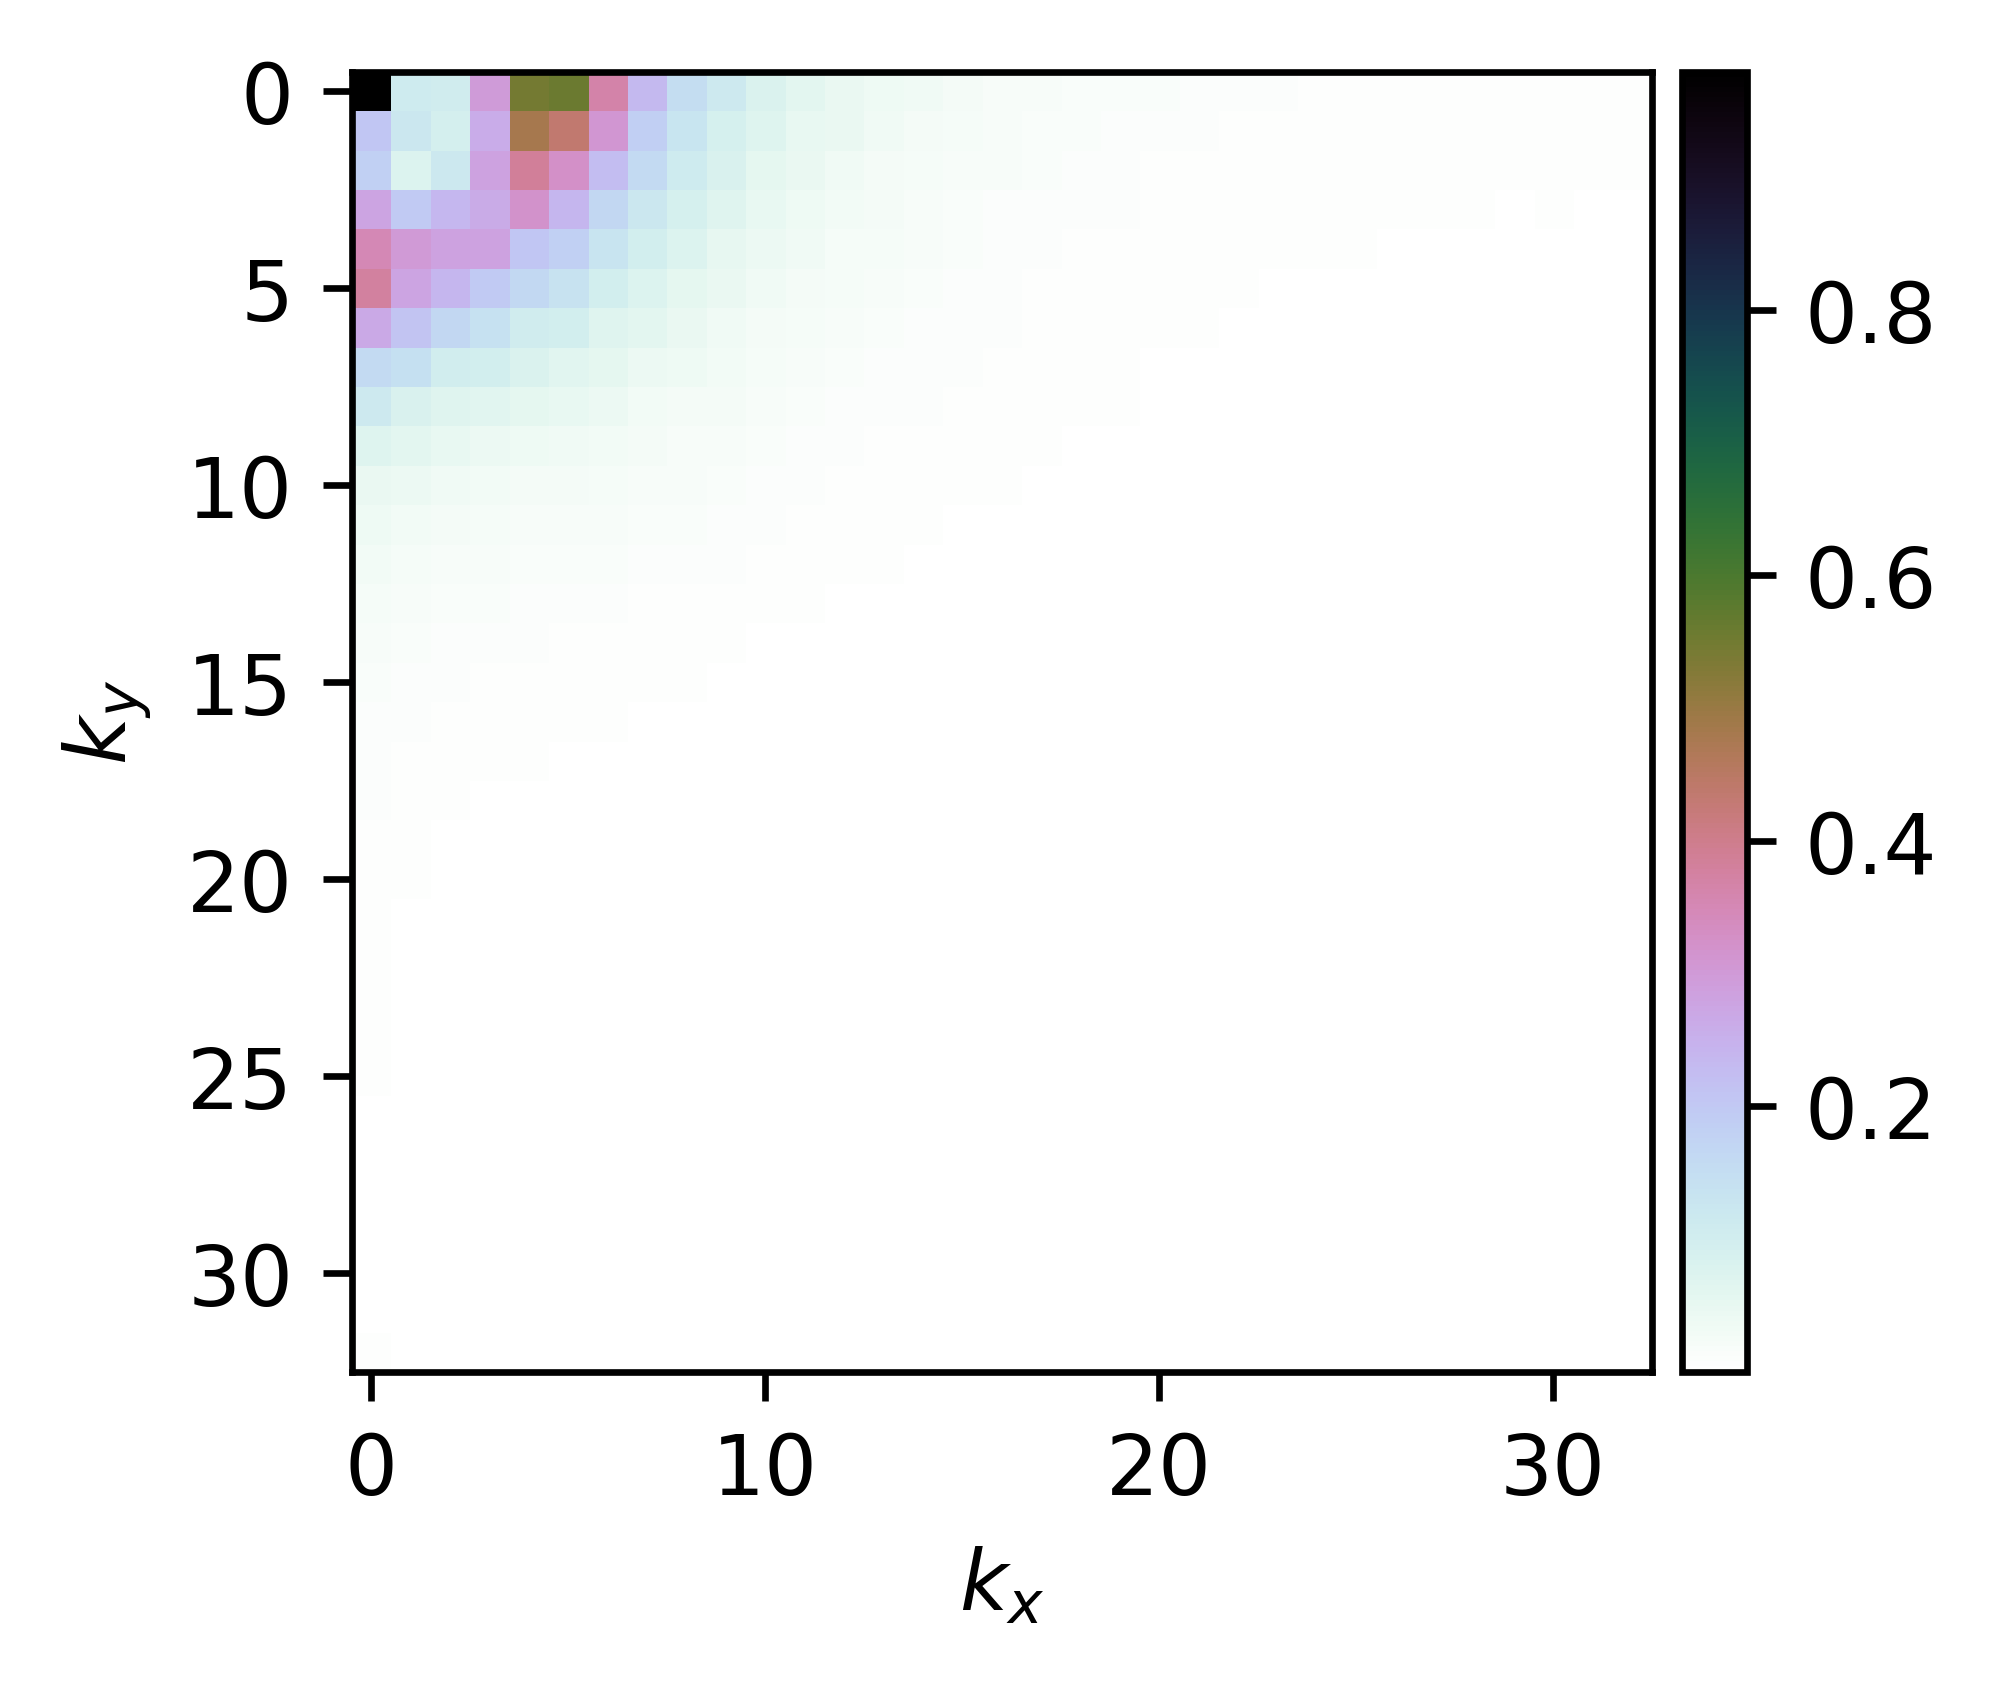

In [11]:
fig, axs = plt.subplots(1, 1, dpi=600, figsize=(3, 3), sharex=True, sharey=True)

s_of_k = np.zeros((33, 33))

# params = _params


this_s = mse_g_params


min_k = 0
# print(f"min k : {min_k}")
# max_k = (N)//2
max_k = (N)//2 + 1
# print(f"max k : {max_k}")

for _kx in range(min_k, max_k):
    for _ky in range(min_k, max_k):
        s_of_k[_kx, _ky] += this_s[_kx*33 + _ky]

im = axs.imshow(
    s_of_k, 
    # cmap='Greys',
    cmap='cubehelix_r',
    )
axs.set_xlabel(r'$k_x$')
axs.set_ylabel(r'$k_y$')

divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)  # Size is width, pad is spacing
fig.colorbar(im, cax=cax)



/var/folders/k5/f6wjdcgd45n9wdxqb2g5v86m8nrvk5/T/ipykernel_24580/3039026674.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  s_of_k[_kx, _ky] += this_s[_kx*33 + _ky]


(15.5, -0.5)

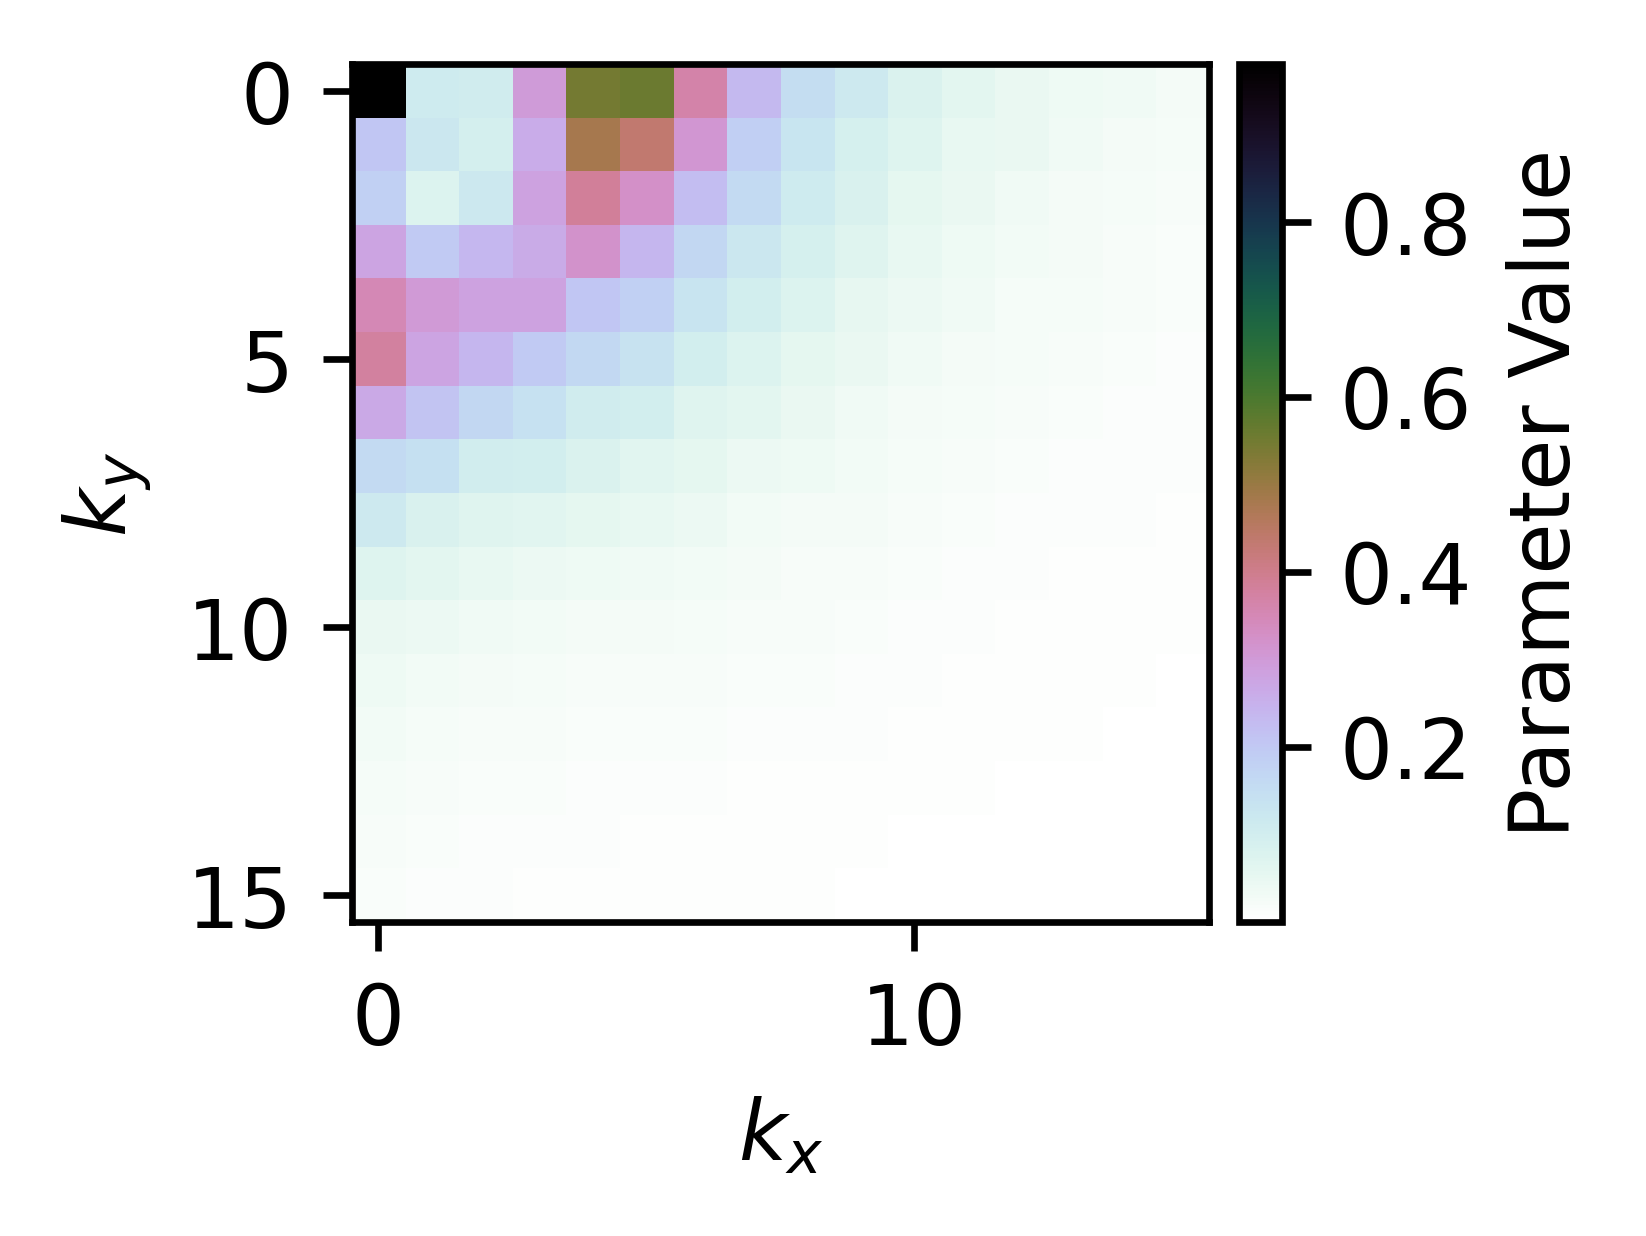

In [12]:
fig, axs = plt.subplots(1, 1, dpi=600, figsize=(2, 2), sharex=True, sharey=True)

s_of_k = np.zeros((33, 33))

# params = _params


this_s = mse_g_params


min_k = 0
# print(f"min k : {min_k}")
# max_k = (N)//2
max_k = (N)//2 + 1
# print(f"max k : {max_k}")

for _kx in range(min_k, max_k):
    for _ky in range(min_k, max_k):
        s_of_k[_kx, _ky] += this_s[_kx*33 + _ky]

im = axs.imshow(
    s_of_k, 
    # cmap='Greys',
    cmap='cubehelix_r',
    )
axs.set_xlabel(r'$k_x$')
axs.set_ylabel(r'$k_y$')

divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)  # Size is width, pad is spacing
fig.colorbar(im, cax=cax, label='Parameter Value')

axs.set_xlim(-0.5, 15.5)
axs.set_ylim(15.5, -0.5)



In [13]:
axs.get_xlim()

(-0.5, 15.5)

In [14]:
# np.save('cov_param_fits_global_mseStart.npy', params)

Plot by pixel seperation

In [15]:

def get_r(x, y):
    return np.sqrt(np.subtract.outer(x, x)**2 +  np.subtract.outer(y, y)**2)


def pow_exp_correlation(r, a=1, alpha=1): 
    """ Powered exponential correlation
        a > 0
        0 < alpha < 2
        """
    c = torch.exp(-(r/a)**alpha)
    # c[r == 0] = 1e-8
    return c

def pow_exp_cov(r, sigma, tau, a, alpha):
    """
    """
    c_term = sigma**2 * pow_exp_correlation(r, a=a, alpha=alpha)
    if c_term.ndim == 2:
        tau_term = torch.diag_embed(torch.Tensor([tau]*len(c_term)))
    elif c_term.ndim == 1:
        tau_term = torch.zeros_like(c_term)
        tau_term[0] = tau
    
    return c_term + tau_term

# K = hr_data_size
K = 64
x = np.arange(0, K)
xg = np.tile(x, K)            # generates x-coordinates for the entire grid K*K 
yg = np.repeat(x, K, axis=0)
pixel_sep = get_r(xg, yg)


In [16]:
pixel_sep_rav = pixel_sep.ravel()

## Sort values by pixel distance
pixel_sep_sort_args = np.argsort(pixel_sep_rav)
# _sorted = [i for _, i in sorted(zip(pixel_sep_rav, _fit_cov.ravel()))]

mse_sorted = mse_g_fit_cov.ravel()[pixel_sep_sort_args]
sorted_pixel_sep = pixel_sep_rav[pixel_sep_sort_args]


In [17]:

## Use pandas to compute mean across unique pizel separations
mse_g_cov_series = pd.DataFrame(mse_sorted, sorted_pixel_sep)
mse_g_cov_series_mean = mse_g_cov_series.groupby(mse_g_cov_series.index.round(0)).mean()
mse_g_cov_series_stdd = mse_g_cov_series.groupby(mse_g_cov_series.index.round(0)).std()

In [18]:
mse_global_cov_by_pix_sep = mse_g_cov_series_mean.values.squeeze()

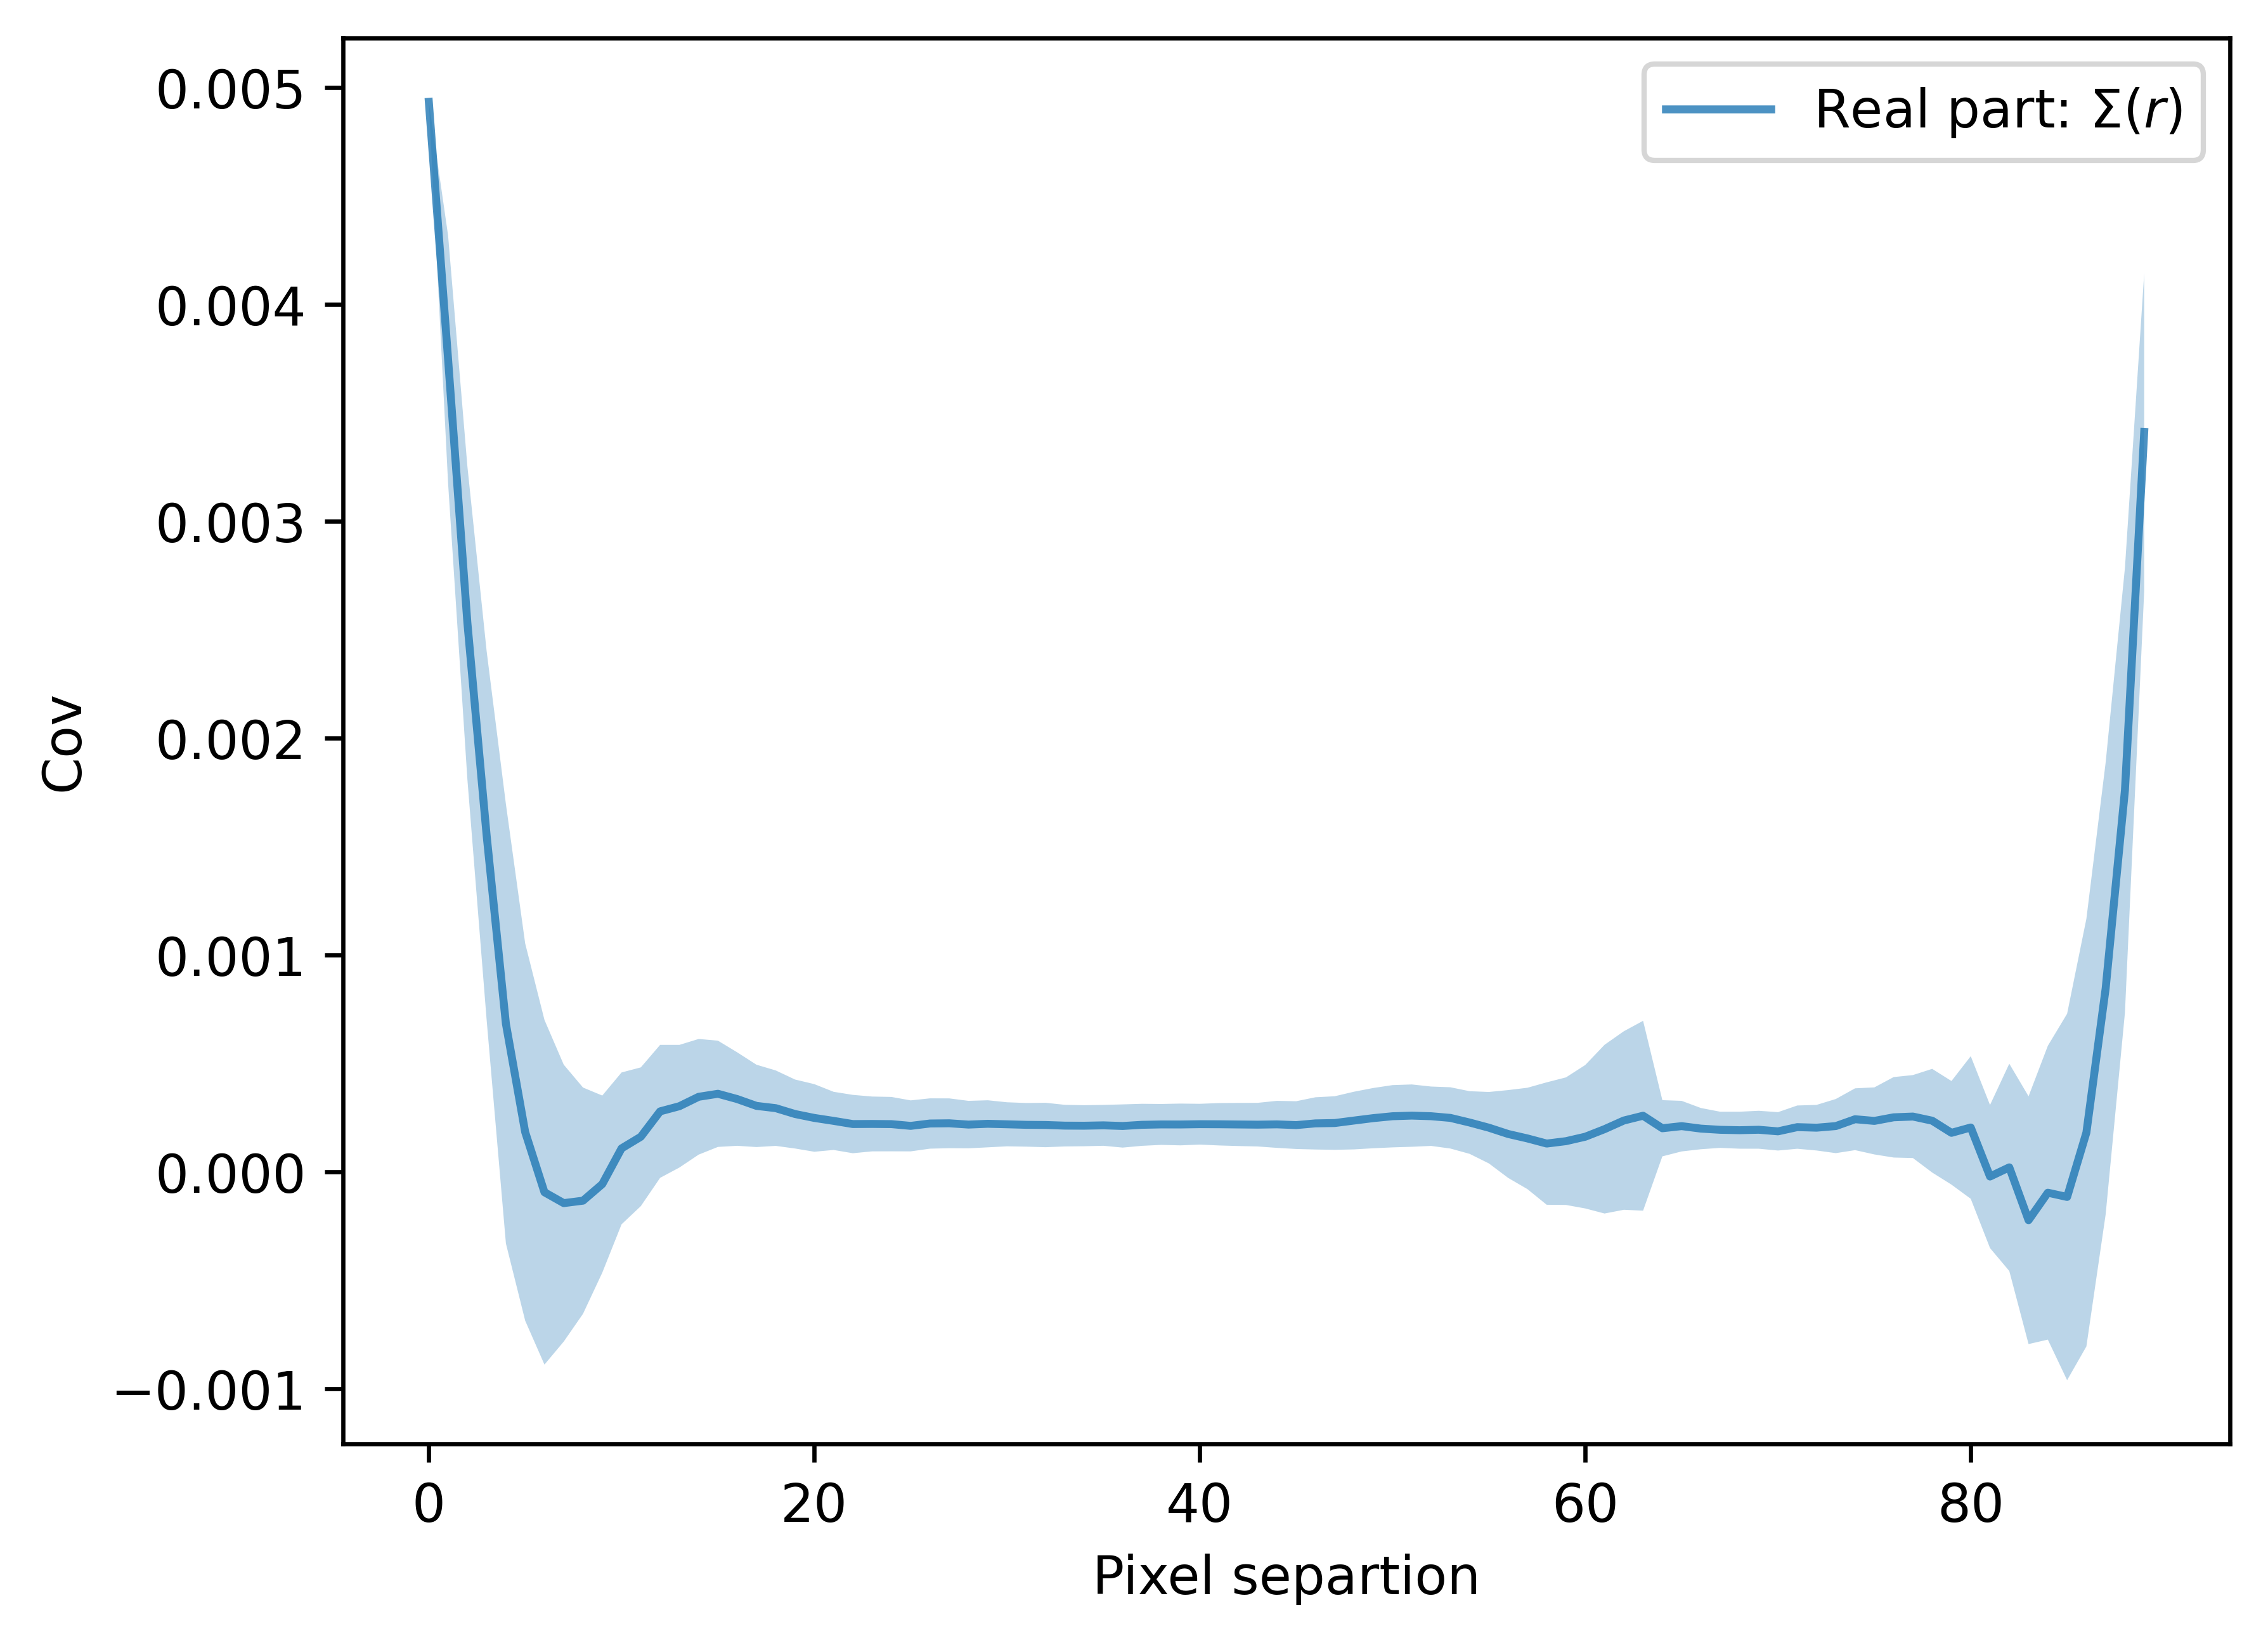

In [19]:
plt.figure(dpi=600)

# fit_params = minimized_params.detach()

# Plot baseline used to generate synthetic data
_r = np.linspace(sorted_pixel_sep[0], sorted_pixel_sep[-1], 100)
# plt.plot(
#     _r, 
#     pow_exp_cov(
#         torch.Tensor(_r), 
#         sigma=np.sqrt(.6),
#         tau=0,
#         a=90, 
#         alpha=1.8
#         ), 
#     color='k', label='fit')

## Plot test prediction correlation with vals averaged over duplicate pixel seperations
_x = mse_g_cov_series_mean.index 
plt.fill_between(
    _x,
    (mse_g_cov_series_mean[0].values - 1*mse_g_cov_series_stdd[0].values),
    (mse_g_cov_series_mean[0].values + 1*mse_g_cov_series_stdd[0].values),
    alpha=.3,
    linewidth=10,
    # label='rolling std'
)
plt.plot(_x, mse_global_cov_by_pix_sep, alpha=.8, label='Real part: $\Sigma(r)$')



plt.ylabel('Cov')
plt.xlabel('Pixel separtion')
plt.legend()



## Load and plot curves from img-specific covarainces

In [20]:
is_mse_params = np.load("../stage_2/anal_sln_img_spec_params.npy")

In [21]:
is_mse_params.T.shape

(1089, 856)

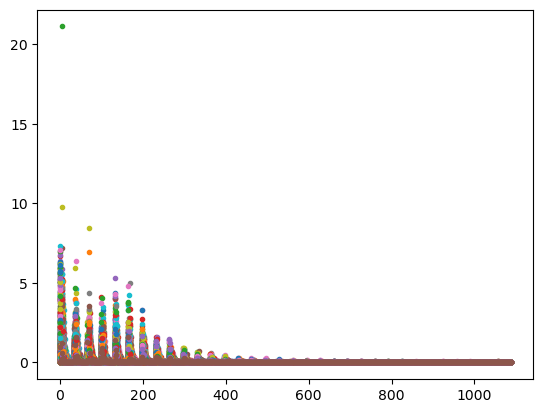

In [22]:
for _params in is_mse_params:
    ims = plt.plot(_params, ls='', marker='.')

/Users/hgoldwyn/opt/anaconda3/envs/torch/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/hgoldwyn/opt/anaconda3/envs/torch/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


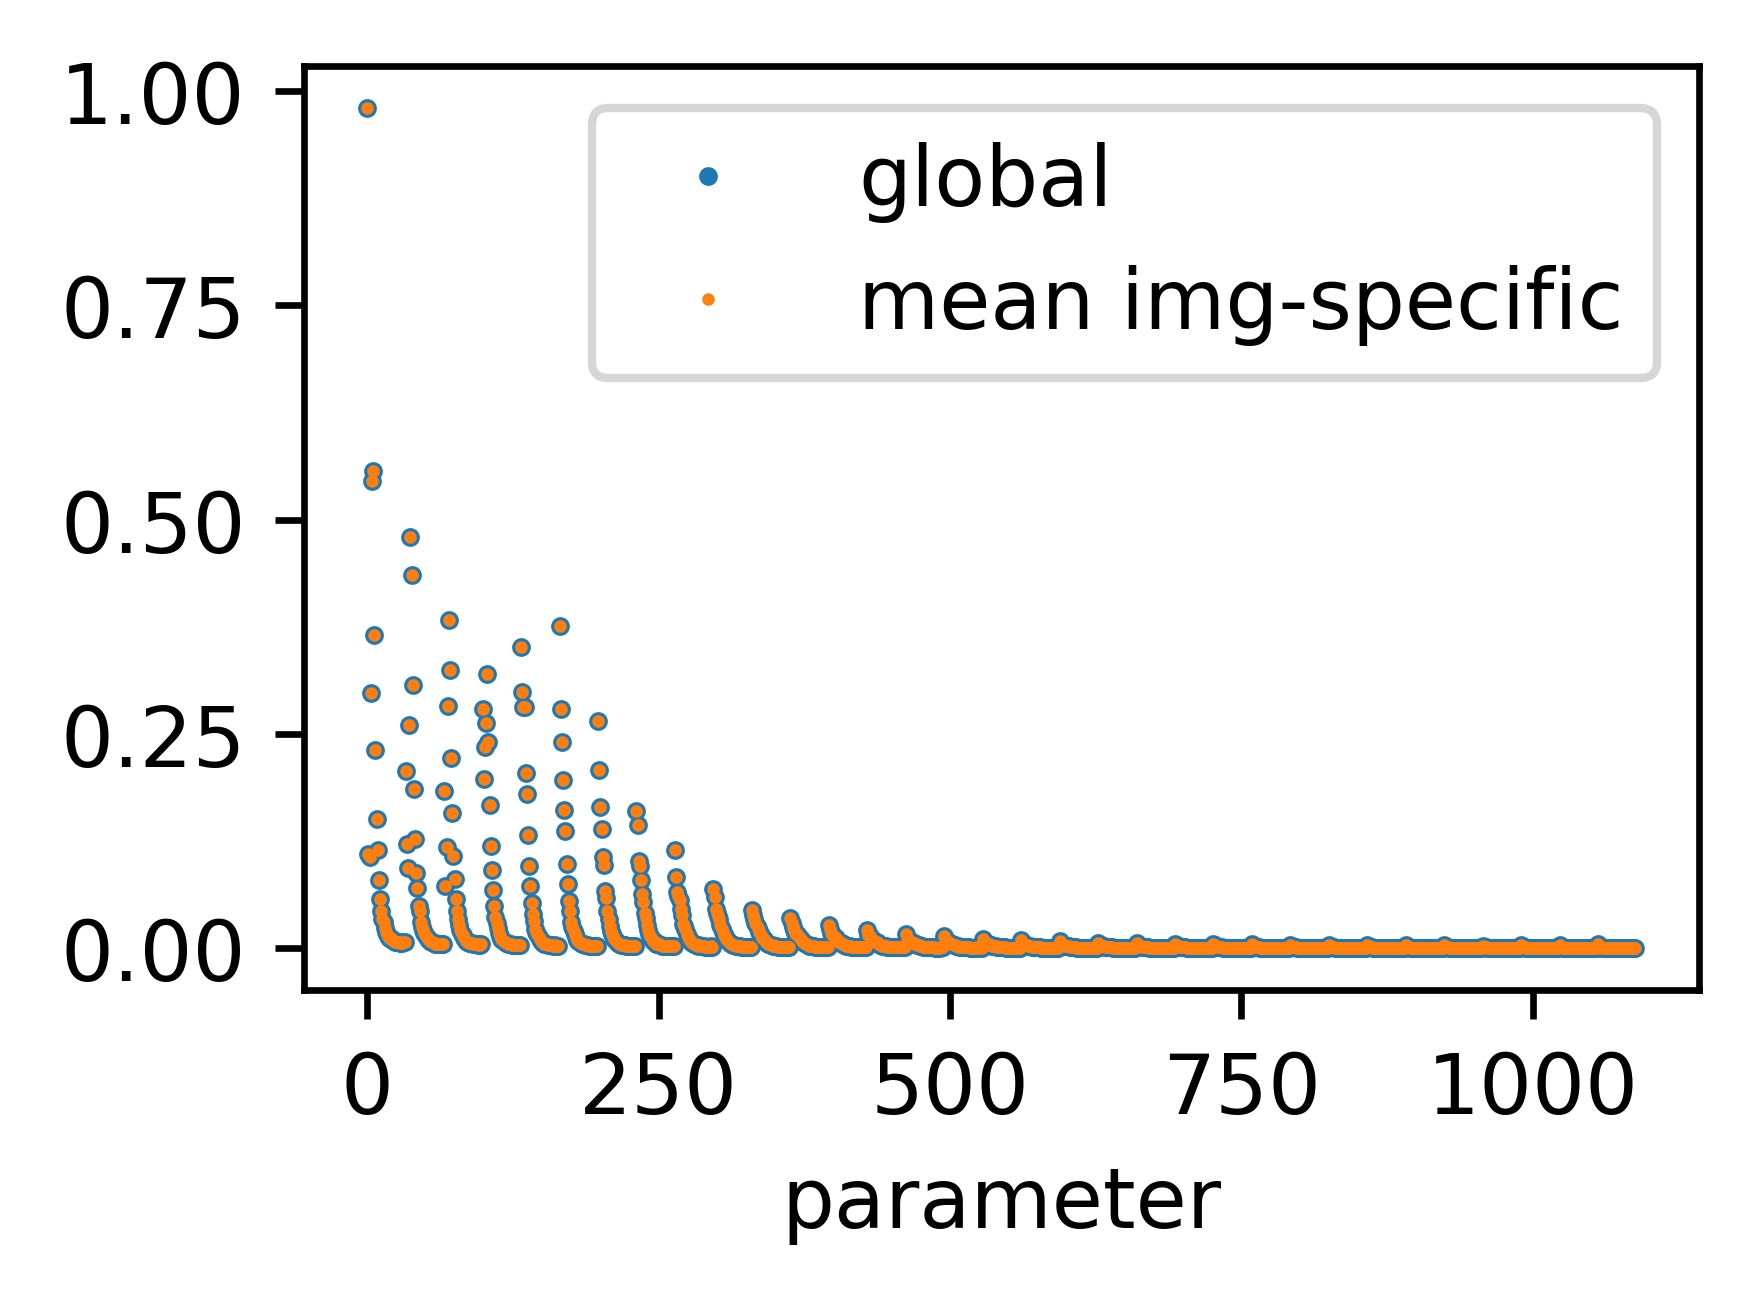

In [23]:
# _params = torch.exp(minimized_params).detach().numpy()
plt.figure(dpi=600, figsize=(3, 2))
plt.plot(mse_g_params, ls='', marker='.',  markersize=2.5, label='global')
ims = plt.plot(is_mse_params.mean(axis=0), ls='', marker='.', markersize=1, label='mean img-specific')
plt.xlabel('parameter')
plt.legend()



In [25]:
# covs = []
# covs_std = []

# for i, params in enumerate(is_mse_params):
#     ## compute covaraince
#     fit_cov = torch.real(
#         torch.matmul(
#             basis_functions_tensor/N, 
#             torch.matmul(
#                 torch.diag_embed(torch.tensor(params, dtype=torch.complex64)),
#                 torch.conj(basis_functions_tensor.T)/N
#                 )
#             )
#         )
    
#     # pixel_sep_sort_args = np.argsort(pixel_sep_rav)
#     # _sorted = [i for _, i in sorted(zip(pixel_sep_rav, _fit_cov.ravel()))]

#     _sorted = fit_cov.ravel()[pixel_sep_sort_args]
#     sorted_pixel_sep = pixel_sep_rav[pixel_sep_sort_args]

#     ## Use pandas to compute mean across unique pizel separations
#     cov_series = pd.DataFrame(_sorted, sorted_pixel_sep)
#     cov_series_mean = cov_series.groupby(cov_series.index.round(0)).mean()
#     cov_series_stdd = cov_series.groupby(cov_series.index.round(0)).std()

#     covs.append(cov_series_mean)
#     covs_std.append(cov_series_stdd)


In [26]:
# covs_np = np.array([cov.values for cov in covs])
# covs_std_np = np.array([cov.values for cov in covs_std])

In [27]:
# covs_np = covs_np.squeeze()
# covs_std_np = covs_std_np.squeeze()

In [28]:
# covs_np.shape

In [29]:
# np.save('unreg_cov_per_pixel_sep_per_img.npy', covs_np)
# # np.save('unreg_cov_per_pixel_sep_per_img_stdd.npy', covs_std_np)

covs_np = np.load('unreg_cov_per_pixel_sep_per_img.npy')
covs_std_np = np.load('unreg_cov_per_pixel_sep_per_img_stdd.npy')

In [ ]:
# is_mse_params = np.load("/Users/hgoldwyn/Research/projects/SR_CNN/sr_cnn/real_data/torch/scripts/parCov_fitting/mse/params_from_kestrel/cov_param_fits_noJprior.npy")

Plot by k

In [30]:
n_bf = basis_functions_tensor.shape[1]

min_k = 0
max_k = (N)//2 + 1

k_per_mode = []
k_vec_per_mode = []
for _kx in range(min_k, max_k):
    for _ky in range(min_k, max_k):
        k_per_mode.append((_kx**2 + _ky**2)**0.5)
        k_vec_per_mode.append([_kx, _ky])
k_per_mode = np.asarray(k_per_mode)
k_vec_per_mode = np.asarray(k_vec_per_mode)
k_per_mode.round(1)

s_lim = int(k_per_mode.round(0).max())
split_basis_function_tensor = torch.zeros(s_lim, N**2, n_bf, dtype=torch.complex64).to(device)

In [31]:
mean_is_mse_params = is_mse_params.mean(axis=0)

In [32]:
np.argwhere(k_per_mode.round(0) == 1).shape

(3, 1)

In [33]:
k_per_mode.shape

(1089,)

In [34]:
_slice = np.argwhere(k_per_mode.round(0) == 2)

mean_is_mse_params[_slice.squeeze()]

array([0.10707914, 0.09381456, 0.18371337, 0.07276597])

In [35]:
_slice = np.argwhere(k_per_mode.round(0) == 1)

is_mse_params[..., _slice.squeeze()].shape

(856, 3)

In [36]:
avg_is_mse_params_by_k = []
avg_is_mse_params_by_k_w_k = None

## global
avg_g_mse_params_by_k = []
g_mse_params_by_k_w_k = None

for i in range(s_lim):
    ## Put modes into big tensor corresponding to the right wavenumber
    _slice = np.argwhere(k_per_mode.round(0) == i)

    ## Get avg
    avg_is_mse_params_by_k.append(mean_is_mse_params[_slice.squeeze()].mean())

    ## assign k value
    _vals = mean_is_mse_params[_slice]
    _vals_w_idx = np.concatenate((np.ones_like(_vals)*i, _vals), axis=1)
    if avg_is_mse_params_by_k_w_k is None:
        avg_is_mse_params_by_k_w_k = _vals_w_idx
    else:
        avg_is_mse_params_by_k_w_k = np.concatenate((avg_is_mse_params_by_k_w_k, _vals_w_idx))

    ## Global
    avg_g_mse_params_by_k.append(mse_g_params[_slice.squeeze()].mean())

    _vals = mse_g_params[_slice]
    _vals_w_idx = np.concatenate((np.ones_like(_vals)*i, _vals), axis=1)
    if g_mse_params_by_k_w_k is None:
        g_mse_params_by_k_w_k = _vals_w_idx
    else:
        g_mse_params_by_k_w_k = np.concatenate((g_mse_params_by_k_w_k, _vals_w_idx))
    
avg_is_mse_params_by_k = np.asarray(avg_is_mse_params_by_k)
avg_g_mse_params_by_k = np.asarray(avg_g_mse_params_by_k)

Compute image-specific params averaged per k

In [37]:
is_mse_params_by_k_w_k_avg_by_k = np.zeros((856, 45, 2))

for j in range(is_mse_params.shape[0]):
    _this_is_mse_params_by_k_w_k_avg_by_k = None
    for i in range(s_lim):

        _slice = np.argwhere(k_per_mode.round(0) == i)

        ## assign k value
        _vals = np.atleast_1d(is_mse_params[j, _slice].mean())
        _vals_w_idx = np.atleast_2d(np.concatenate((np.ones_like(_vals)*i, _vals), axis=0))
        if _this_is_mse_params_by_k_w_k_avg_by_k is None:
            _this_is_mse_params_by_k_w_k_avg_by_k = _vals_w_idx
        else:
            _this_is_mse_params_by_k_w_k_avg_by_k = np.concatenate((_this_is_mse_params_by_k_w_k_avg_by_k, _vals_w_idx))

    is_mse_params_by_k_w_k_avg_by_k[j, :, :] = _this_is_mse_params_by_k_w_k_avg_by_k
    # break

/Users/hgoldwyn/opt/anaconda3/envs/torch/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/hgoldwyn/opt/anaconda3/envs/torch/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


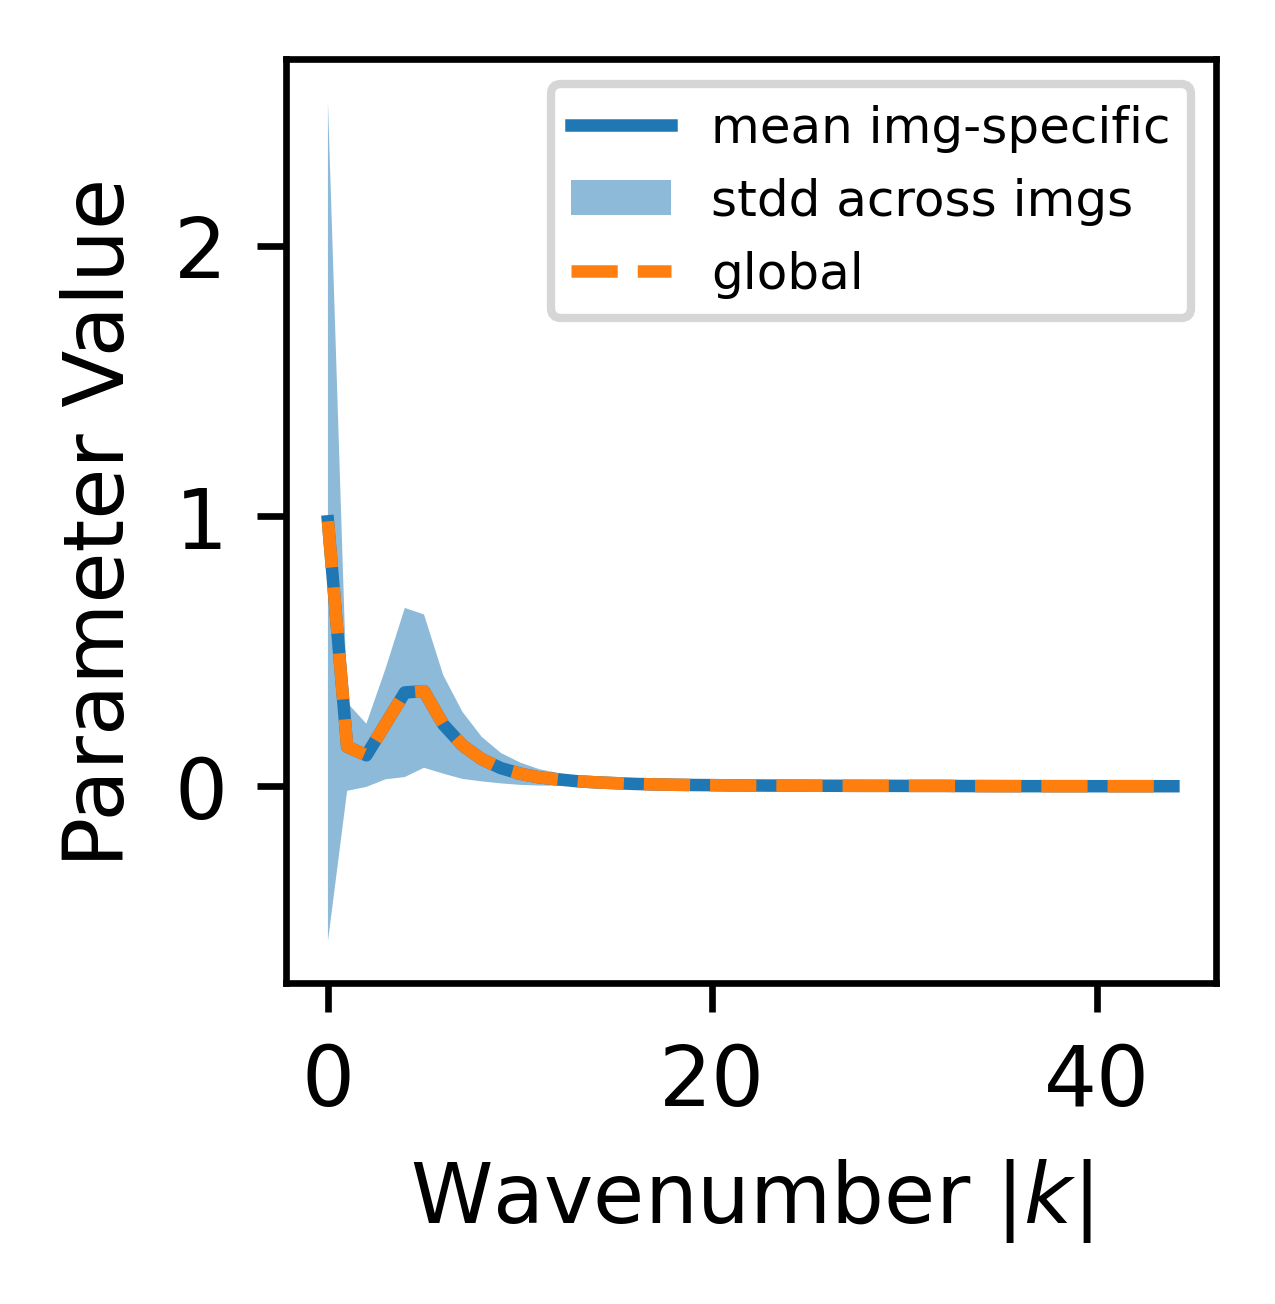

In [38]:
plt.figure(dpi=600, figsize=(2, 2))
plt.plot(avg_is_mse_params_by_k, label='mean img-specific')

_mean = is_mse_params_by_k_w_k_avg_by_k.mean(axis=0)[:, 1]
_stdd = is_mse_params_by_k_w_k_avg_by_k.std(axis=0)[:, 1]

# plt.plot(
#     range(45), _mean, 
#     # ls='', marker='o'
#     )
plt.fill_between(
    range(45),
    _mean - _stdd,
    _mean + _stdd,
    alpha=.5,
    label='stdd across imgs'
)


plt.plot(
    avg_g_mse_params_by_k, 
    label='global',
    ls='--'
    )

plt.xlabel(r'Wavenumber $|k|$')

plt.ylabel('Parameter Value')

plt.legend(fontsize=6)

Make paper figure

(15.5, -0.5)

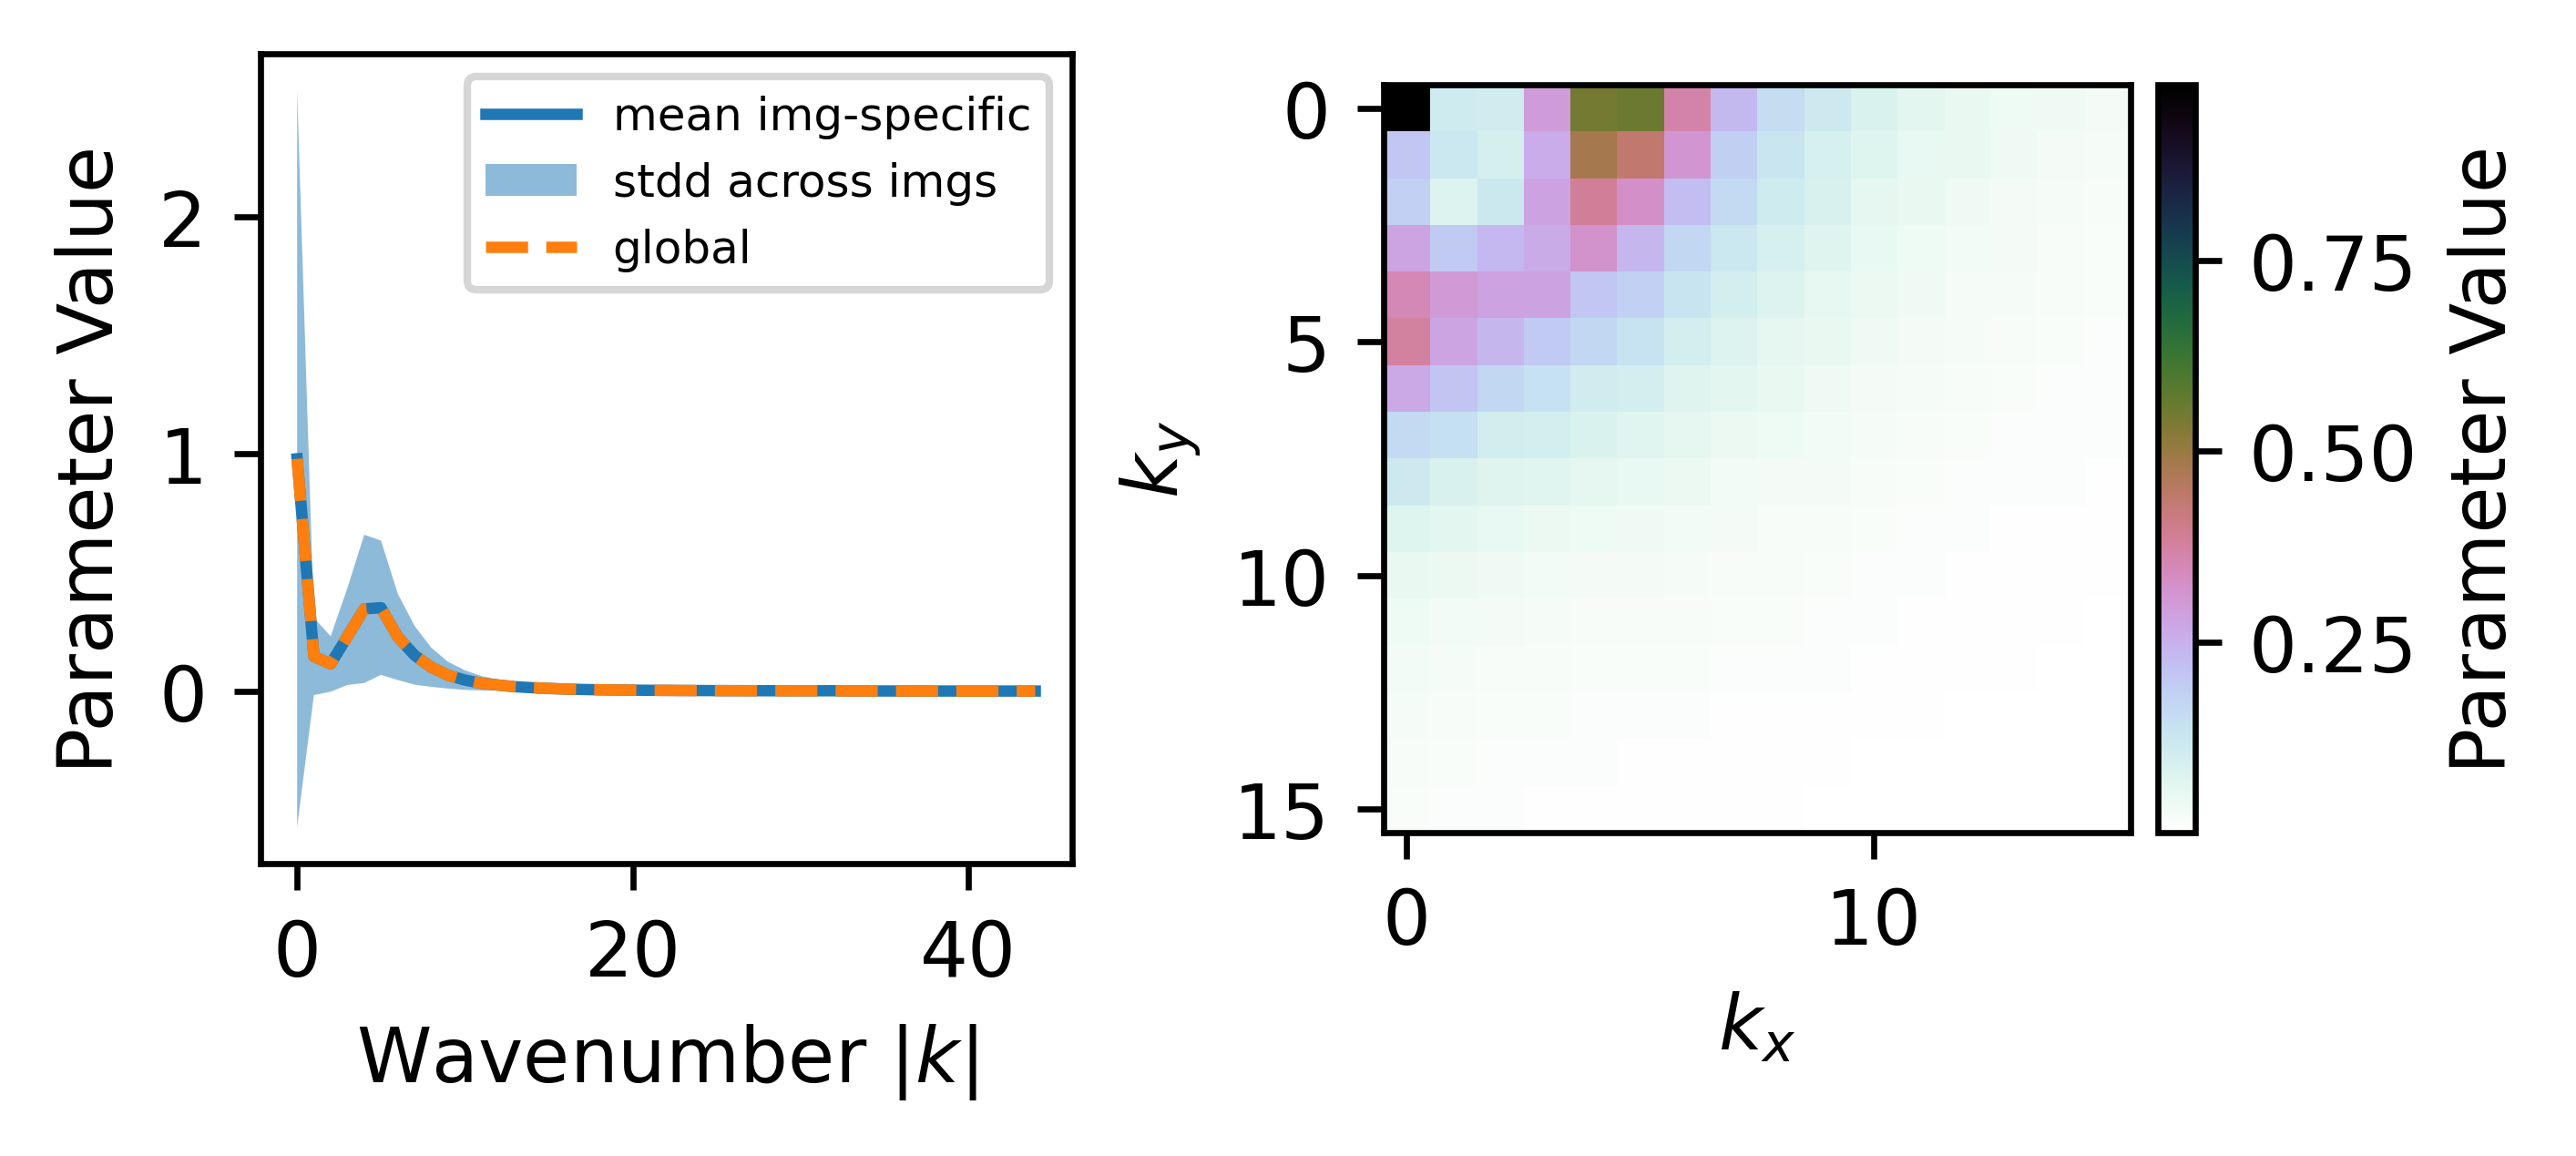

In [49]:
fig, axs = plt.subplots(1, 2, dpi=600, figsize=(4, 2), constrained_layout=True)
axs[0].plot(avg_is_mse_params_by_k, label='mean img-specific')

_mean = is_mse_params_by_k_w_k_avg_by_k.mean(axis=0)[:, 1]
_stdd = is_mse_params_by_k_w_k_avg_by_k.std(axis=0)[:, 1]

# plt.plot(
#     range(45), _mean, 
#     # ls='', marker='o'
#     )
axs[0].fill_between(
    range(45),
    _mean - _stdd,
    _mean + _stdd,
    alpha=.5,
    label='stdd across imgs'
)


axs[0].plot(
    avg_g_mse_params_by_k, 
    label='global',
    ls='--'
    )

axs[0].set_xlabel(r'Wavenumber $|k|$')

axs[0].set_ylabel('Parameter Value')

axs[0].legend( fontsize=6)

## Subplot 2

# s_of_k = np.zeros((33, 33))

# this_s = mse_g_params

# min_k = 0
# # print(f"min k : {min_k}")
# # max_k = (N)//2
# max_k = (N)//2 + 1
# # print(f"max k : {max_k}")

# for _kx in range(min_k, max_k):
#     for _ky in range(min_k, max_k):
#         s_of_k[_kx, _ky] += this_s[_kx*33 + _ky]

im = axs[1].imshow(
    s_of_k, 
    # cmap='Greys',
    cmap='cubehelix_r',
    )
axs[1].set_xlabel(r'$k_x$')
axs[1].set_ylabel(r'$k_y$')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)  # Size is width, pad is spacing
fig.colorbar(im, cax=cax, label='Parameter Value')

axs[1].set_xlim(-0.5, 15.5)
axs[1].set_ylim(15.5, -0.5)



Compute global cov by pixel sep

In [38]:
# pixel_sep_rav = pixel_sep.ravel()

## Sort values by pixel distance
# pixel_sep_sort_args = np.argsort(pixel_sep_rav)
# _sorted = [i for _, i in sorted(zip(pixel_sep_rav, _fit_cov.ravel()))]

anal_mse_sorted = mse_g_fit_cov.ravel()[pixel_sep_sort_args]
# sorted_pixel_sep = pixel_sep_rav[pixel_sep_sort_args]


In [39]:

## Use pandas to compute mean across unique pizel separations
anal_mse_g_cov_series = pd.DataFrame(anal_mse_sorted, sorted_pixel_sep)
anal_mse_g_cov_series_mean = anal_mse_g_cov_series.groupby(anal_mse_g_cov_series.index.round(0)).mean()
anal_mse_g_cov_series_stdd = anal_mse_g_cov_series.groupby(anal_mse_g_cov_series.index.round(0)).std()

In [40]:
anal_mse_global_cov_by_pix_sep = anal_mse_g_cov_series_mean.values.squeeze()

In [41]:
# covs_np = np.load('cov_per_pixel_sep_per_img.npy')
# covs_std_np = np.load('cov_per_pixel_sep_per_img_stdd.npy')

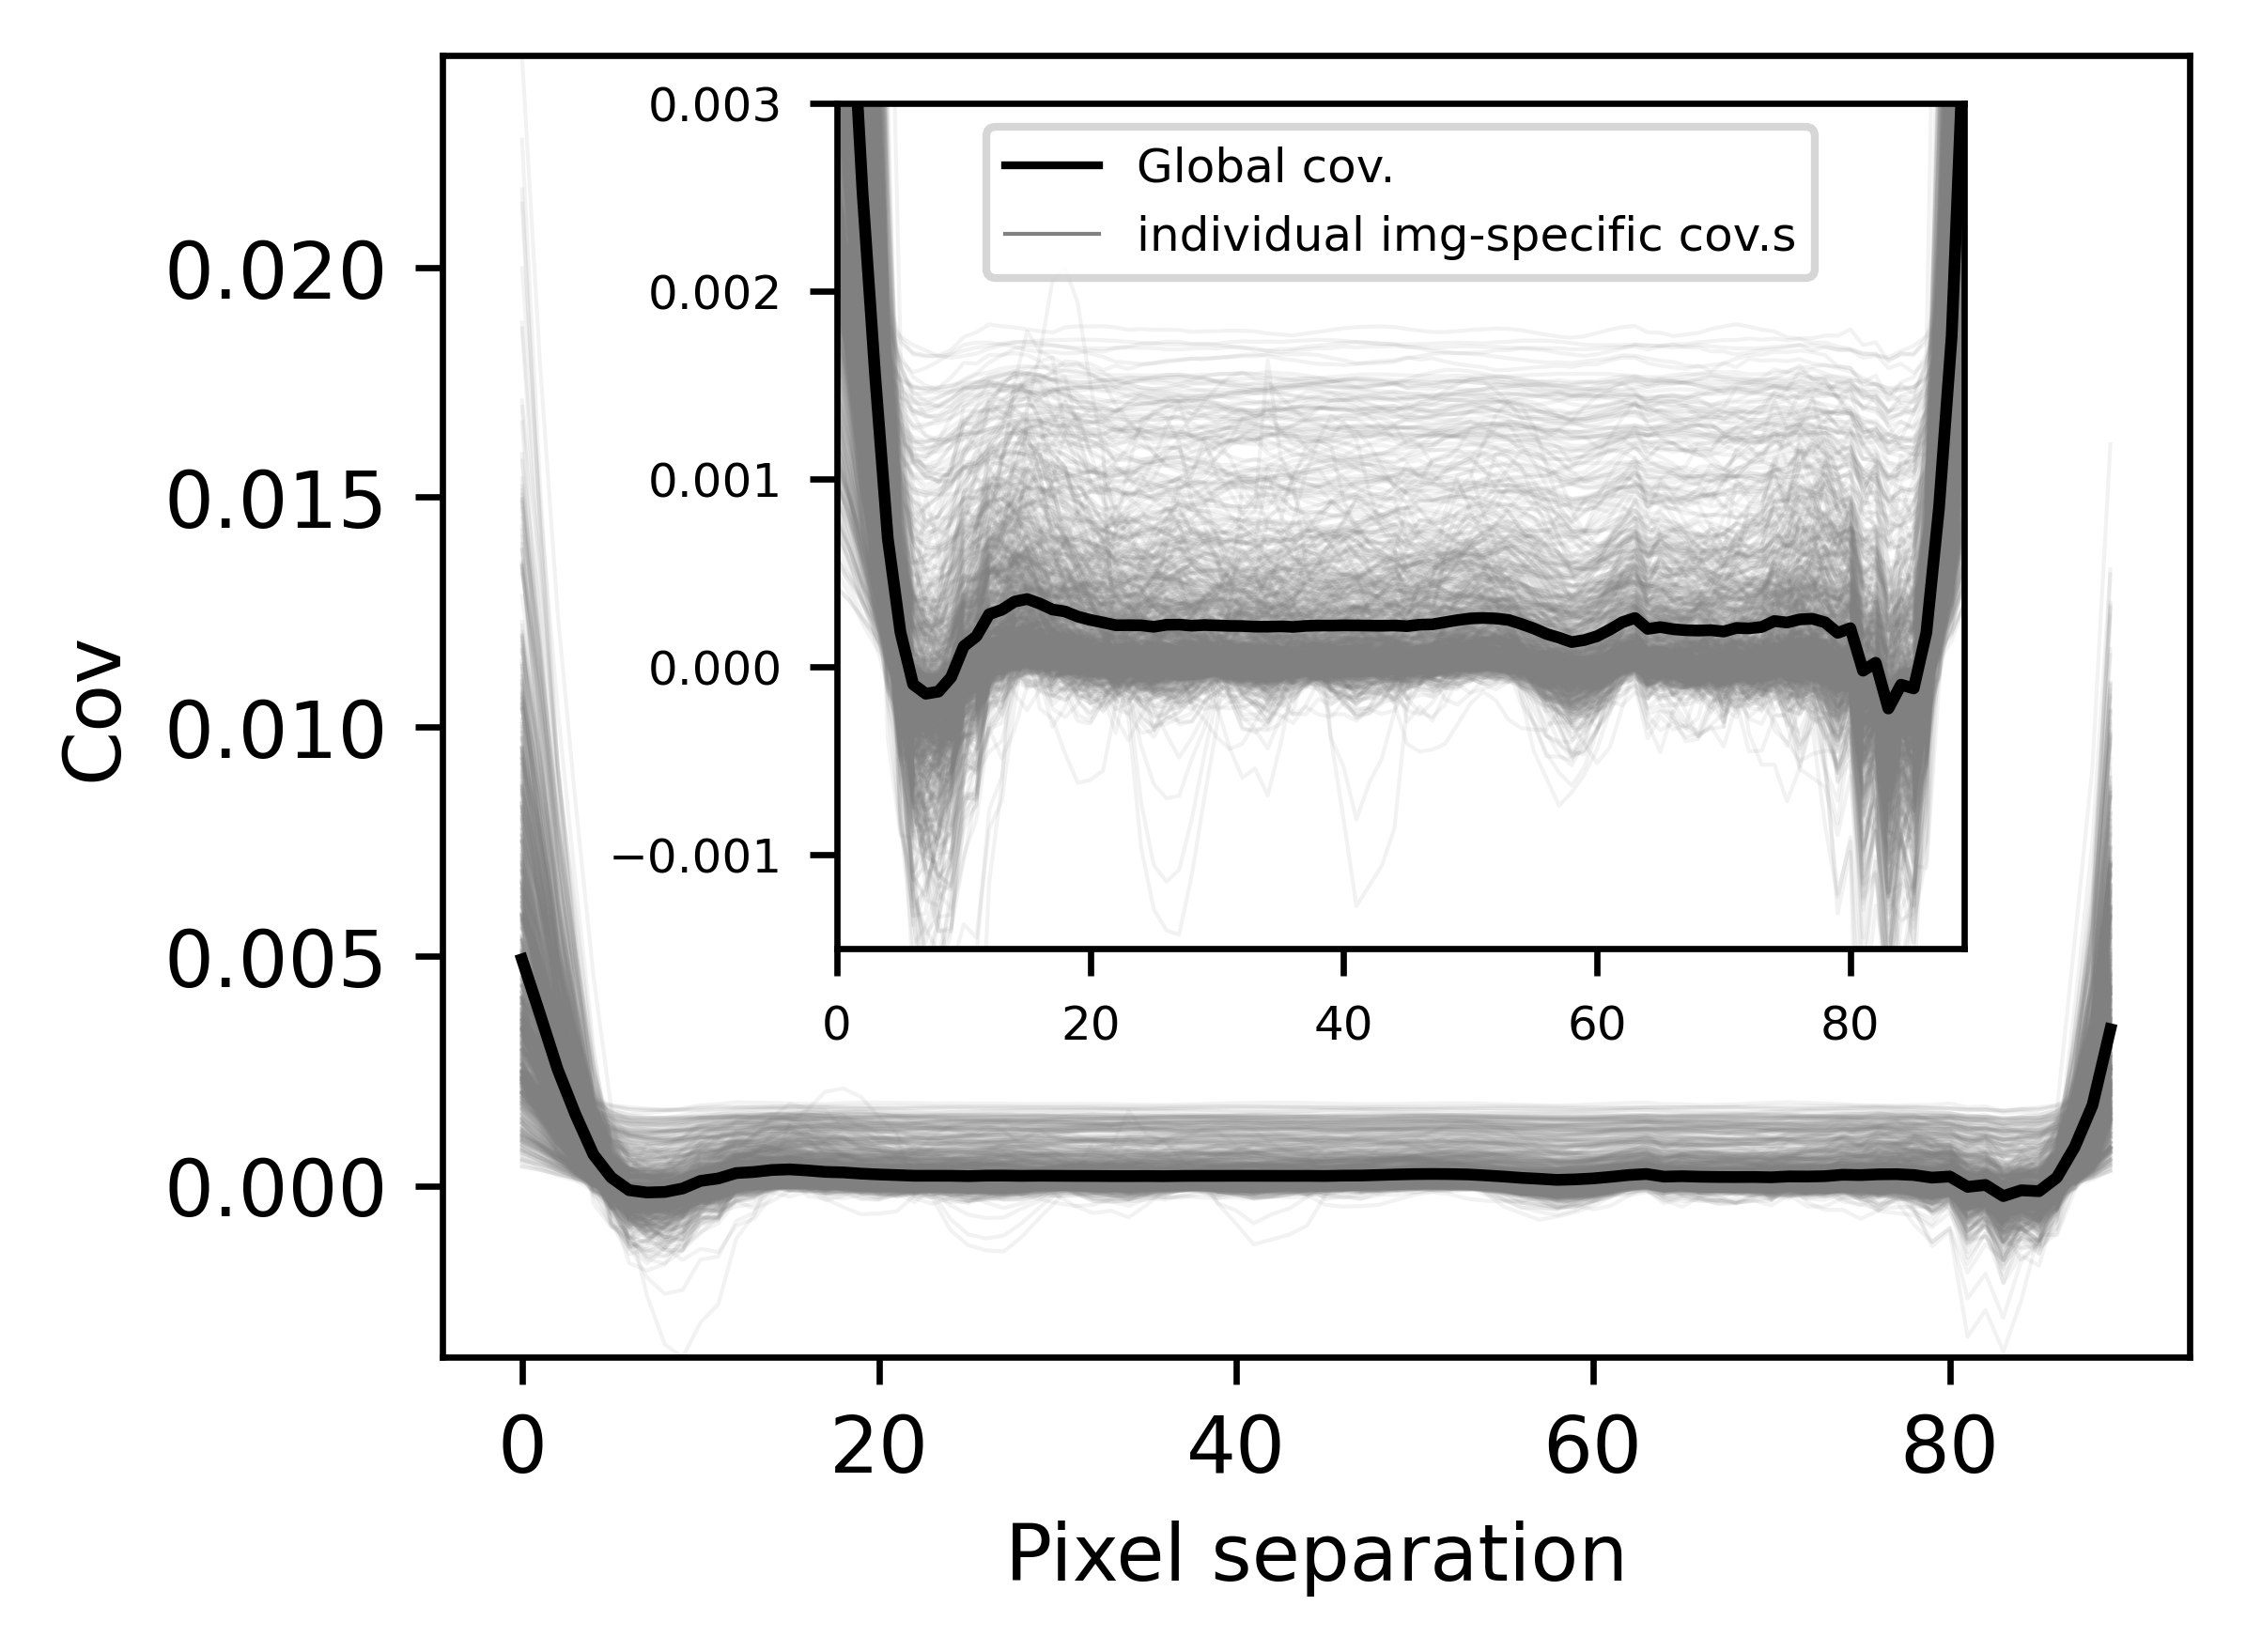

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D


plt.figure(dpi=600, figsize=(4, 3))

# Main plot: full y-range (no "slim restrictions")
plt.plot(_x, covs_np.mean(axis=0), color='k', label='global covariance')
for i, cov in enumerate(covs_np):
    _label = 'individual img-specific cov.s' if i == 0 else None
    plt.plot(_x, cov, alpha=0.1, color='gray', zorder=0, lw=0.5, label=_label)

plt.ylabel('Cov')
plt.xlabel('Pixel separation')
plt.ylim(covs_np.min(), covs_np.max())  # full range

# ~~~ Inset axes with slim y-axis range ~~~
ax_inset = inset_axes(plt.gca(), width="50%", height="50%", loc='upper center',
                      bbox_to_anchor=(0.05, -0.125, 1, 1), bbox_transform=plt.gcf().transFigure)

ax_inset.plot(_x, covs_np.mean(axis=0), color='k')
for cov in covs_np:
    ax_inset.plot(_x, cov, alpha=0.1, color='gray', zorder=0, lw=0.5)

ax_inset.set_ylim(-0.0015, 0.003)  # slim view
ax_inset.set_xlim(_x[0], _x[-1])  # optional: match full x-range
ax_inset.tick_params(labelsize=6)
# ax_inset.set_title("Zoom", fontsize=8)

custom_handles = [
    Line2D([0], [0], color='black', linewidth=1, label='Global cov.'),
    Line2D([], [], color='gray', linewidth=0.5, label='individual img-specific cov.s'),
]
ax_inset.legend(handles=custom_handles, loc='upper center', fontsize=6, frameon=True)

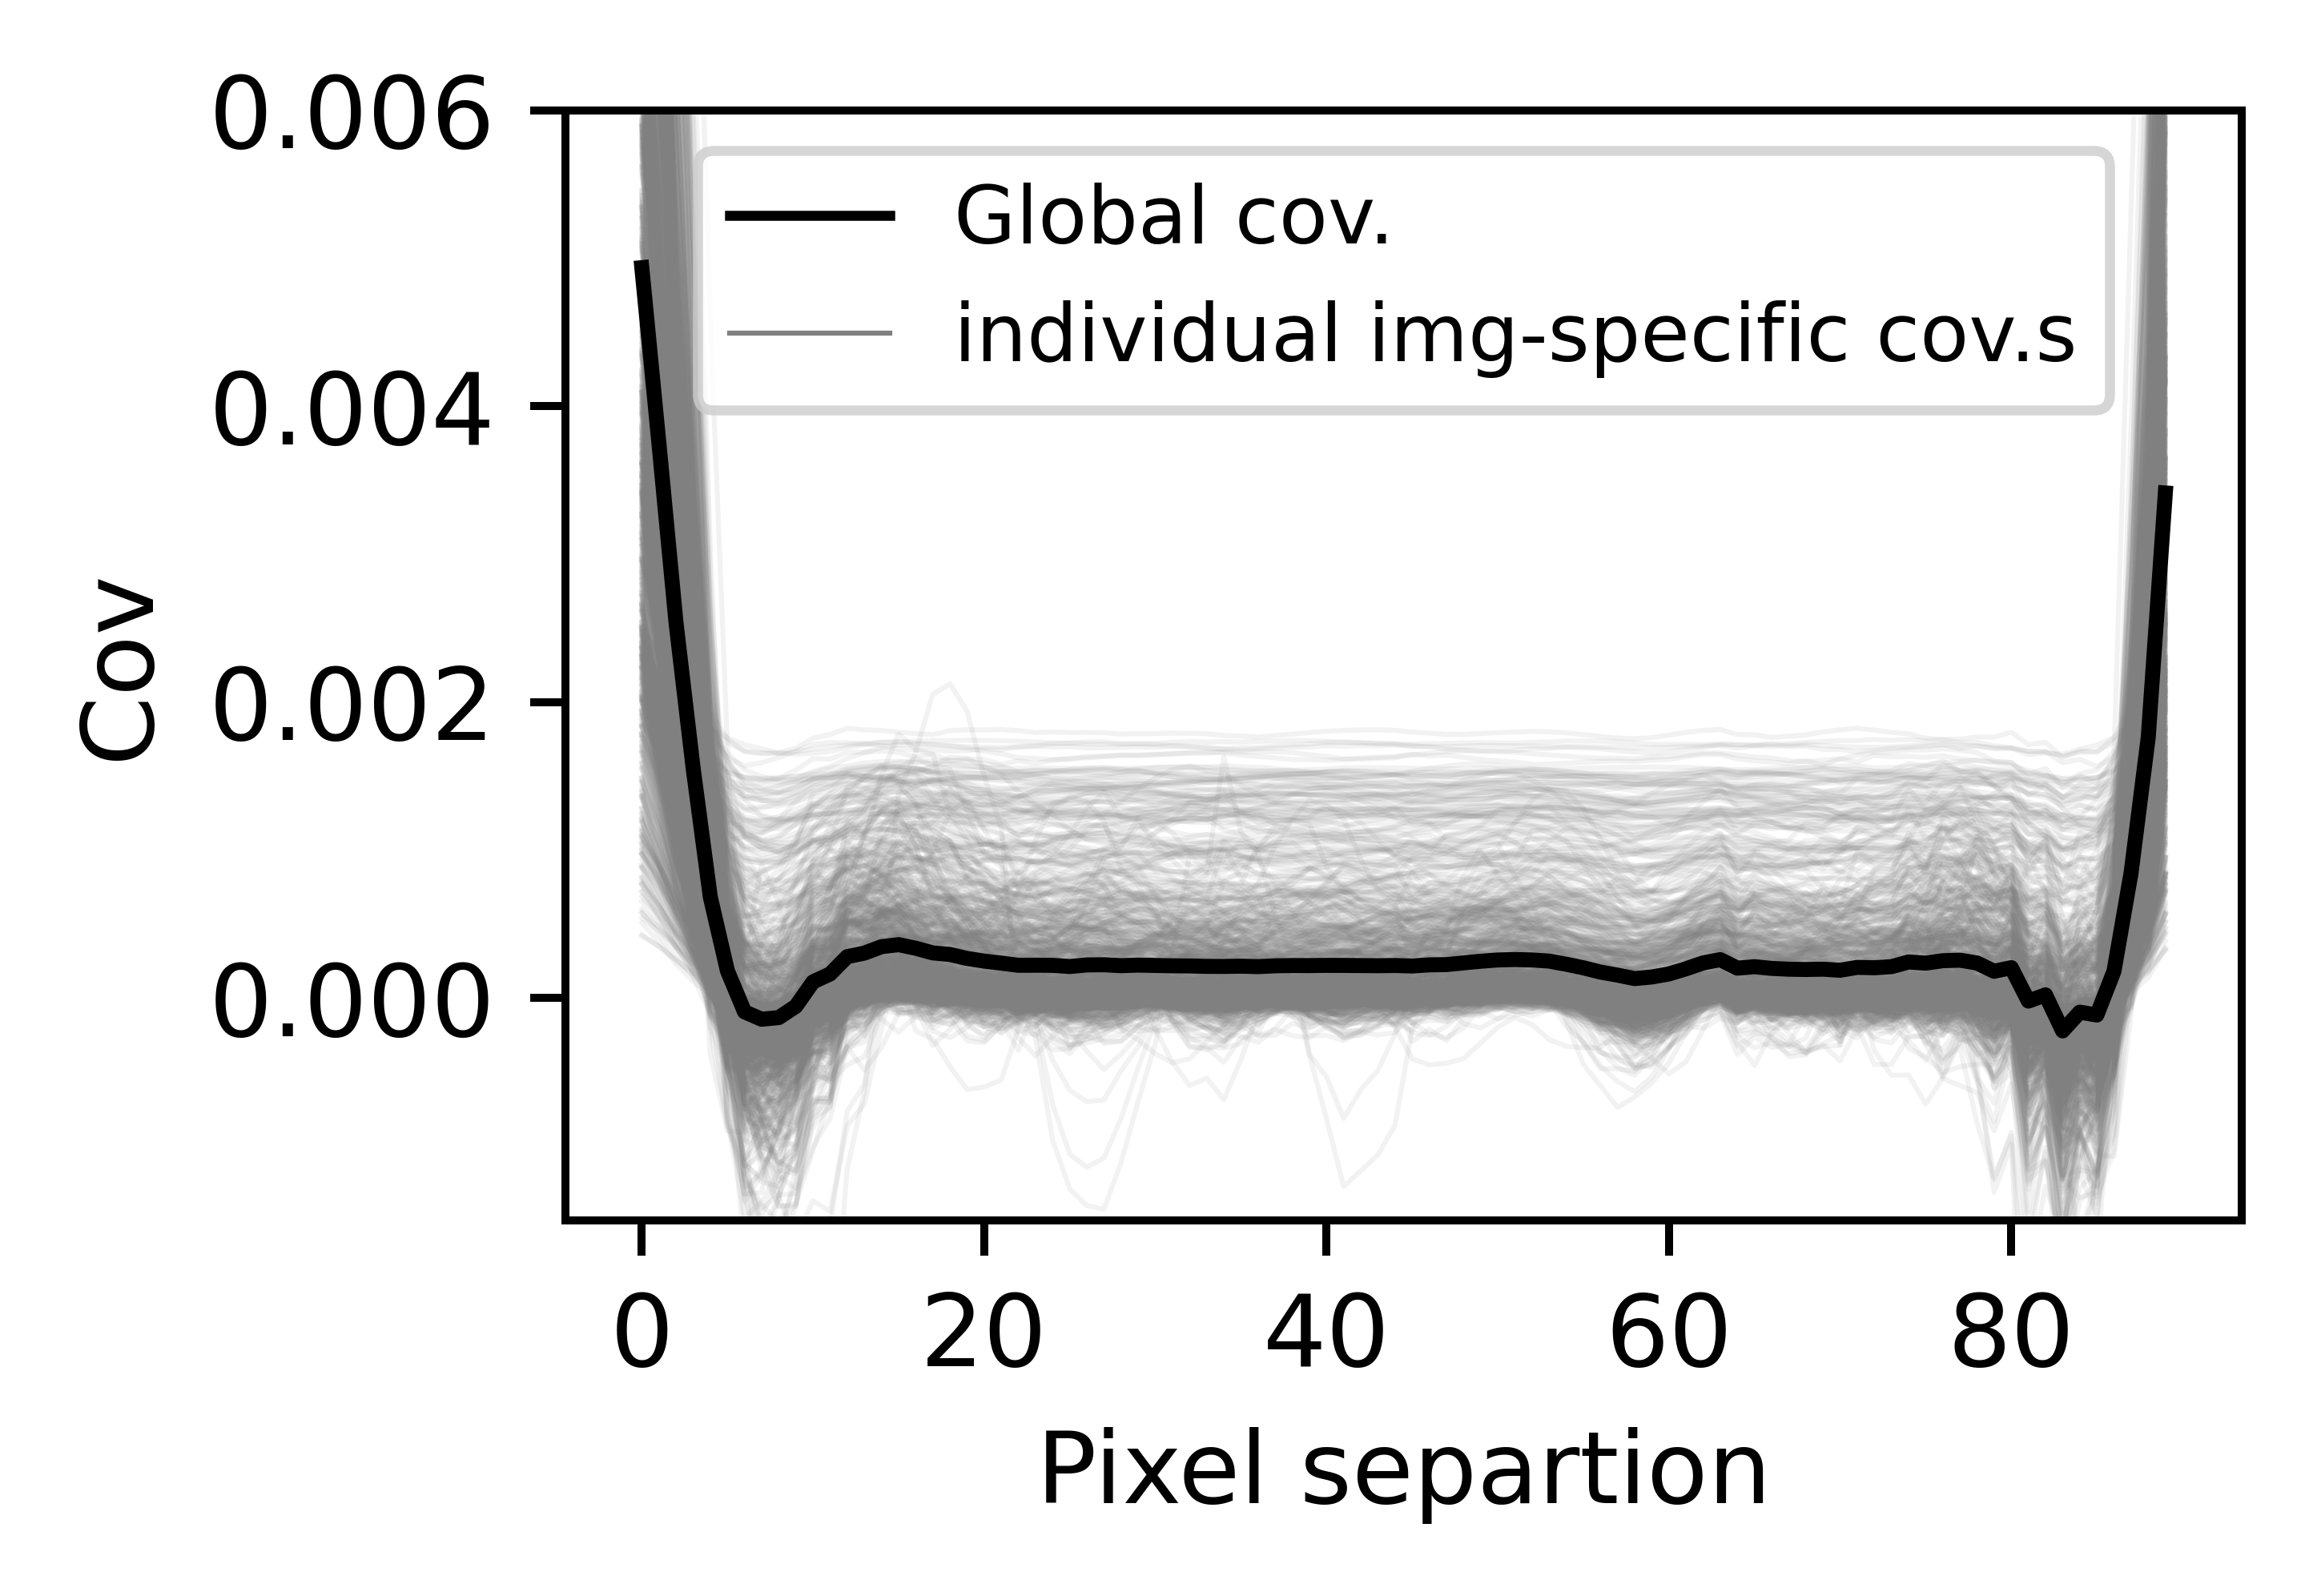

In [43]:
plt.figure(dpi=900, figsize=(3, 2),)

# fit_params = minimized_params.detach()

plt.plot(_x, covs_np.mean(axis=0), color='k', label='global covariance')
for i, cov in enumerate(covs_np):
    if i == 0:
        _label = 'individual img-specific cov.s'
    else:
        _label = None
    plt.plot(_x, cov, alpha=0.1, color='gray', zorder = 0, lw=.5, label=_label)


plt.ylabel('Cov')
plt.xlabel('Pixel separtion')
# plt.legend()
# plt.ylim((-0.0025, 0.01))
plt.ylim((-0.0015, 0.006))

## ~~~ Legend ~~~
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

custom_handles = [
    Line2D([0], [0], color='black', linewidth=1, label='Global cov.'),
    Line2D([], [], color='gray', linewidth=0.5, label='individual img-specific cov.s'),
]

plt.gca().legend(handles=custom_handles, loc='upper center', fontsize=8, frameon=True)
